In [32]:
import pandas as pd
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import statsmodels.api as sm
import warnings
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [33]:
pd.set_option('display.max_columns',None)
df = pd.read_csv('producer-prices_idn.csv')
df.head()

,Iso3,StartDate,EndDate,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Year Code,Year,Months Code,Months,Unit,Value,Flag
0,#country+code,#date+start,#date+end,NaN,NaN,#country+name,#indicator+code,NaN,#indicator+name,NaN,NaN,NaN,#date+year,NaN,NaN,#indicator+type,#indicator+value+num,NaN
1,IDN,1991-01-01,1991-12-31,101.0,'360,Indonesia,809,'01929.07,"Abaca, manila hemp, raw",5539.0,Producer Price Index (2014-2016 = 100),1991.0,1991,7021.0,Annual value,NaN,7.880000,I
2,IDN,1992-01-01,1992-12-31,101.0,'360,Indonesia,809,'01929.07,"Abaca, manila hemp, raw",5539.0,Producer Price Index (2014-2016 = 100),1992.0,1992,7021.0,Annual value,NaN,8.230000,I
3,IDN,1993-01-01,1993-12-31,101.0,'360,Indonesia,809,'01929.07,"Abaca, manila hemp, raw",5539.0,Producer Price Index (2014-2016 = 100),1993.0,1993,7021.0,Annual value,NaN,7.680000,I
4,IDN,1994-01-01,1994-12-31,101.0,'360,Indonesia,809,'01929.07,"Abaca, manila hemp, raw",5539.0,Producer Price Index (2014-2016 = 100),1994.0,1994,7021.0,Annual value,NaN,9.760000,I


### Data Preparation

In [34]:
df.drop(['Iso3','Year','StartDate','Area Code','Area Code (M49)','Item Code','Item Code (CPC)','Element Code','Year Code','Months Code','Flag'],axis=1,inplace=True)
df = df.drop(index=0)

In [35]:
df.dtypes

EndDate    object
Area       object
Item       object
Element    object
Months     object
Unit       object
Value      object
dtype: object

In [36]:
df['Value'] = pd.to_numeric(df['Value'])

In [37]:
df['EndDate'] = pd.to_datetime(df['EndDate'])

### Modelling

In [38]:
item = input("Masukan data yang ingin diprediksi")
item_filter = df['Item'] == item
element_filter = df['Element'] == 'Producer Price Index (2014-2016 = 100)'
months_filter = df['Months'] == 'Annual value'
# Menerapkan filter
df = df[item_filter & element_filter & months_filter].copy()

Masukan data yang ingin diprediksi Abaca, manila hemp, raw


In [39]:
# Menghapus outlier kalau ada
Q1 = df['Value'].quantile(0.25)
Q3 = df['Value'].quantile(0.75)
IQR = Q3 - Q1

# Batas bawah dan atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter
df = df[(df['Value'] >= lower_bound) & (df['Value'] <= upper_bound)]

In [40]:
df = df[['EndDate', 'Value']].sort_values('EndDate')

In [41]:
series = df.set_index('EndDate')['Value']

In [42]:
print(series.head())

EndDate
1991-12-31     7.88
1992-12-31     8.23
1993-12-31     7.68
1994-12-31     9.76
1995-12-31    11.70
Name: Value, dtype: float64


<Axes: xlabel='EndDate'>

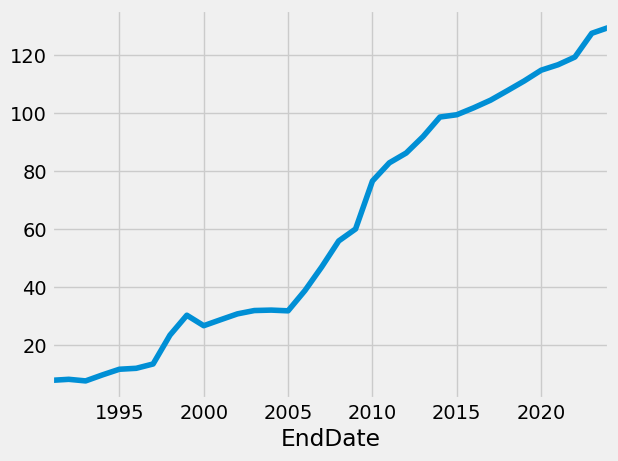

In [43]:
series.plot()

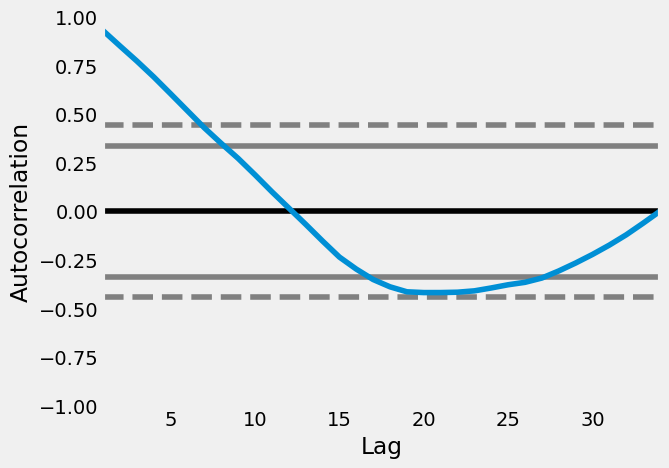

In [44]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.show()

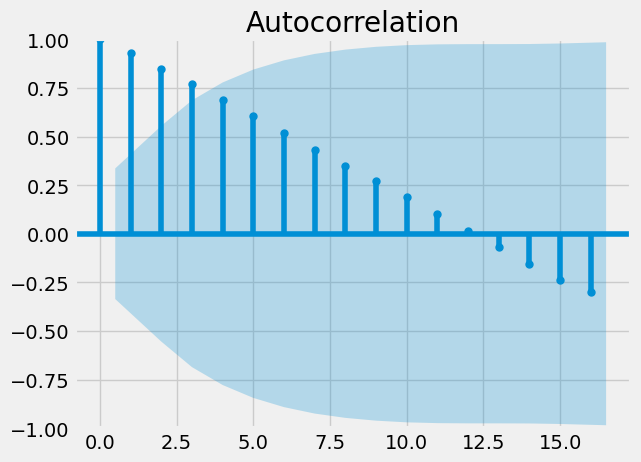

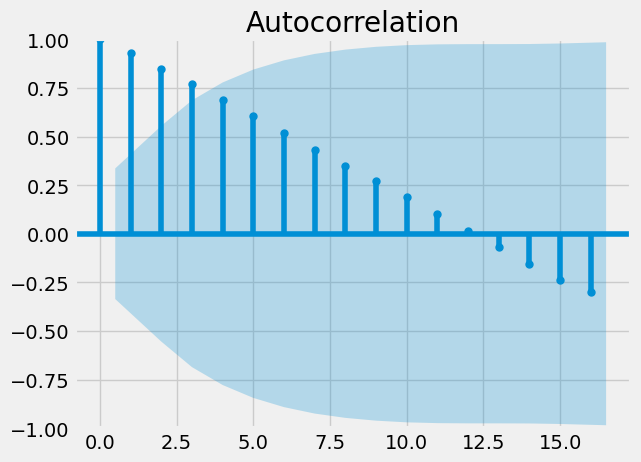

In [45]:
plot_acf(series)

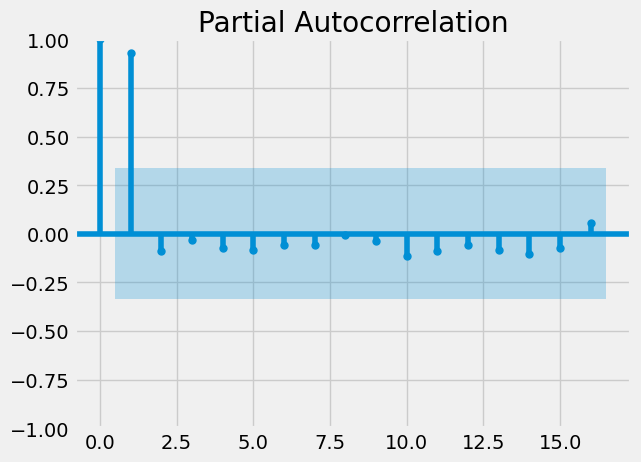

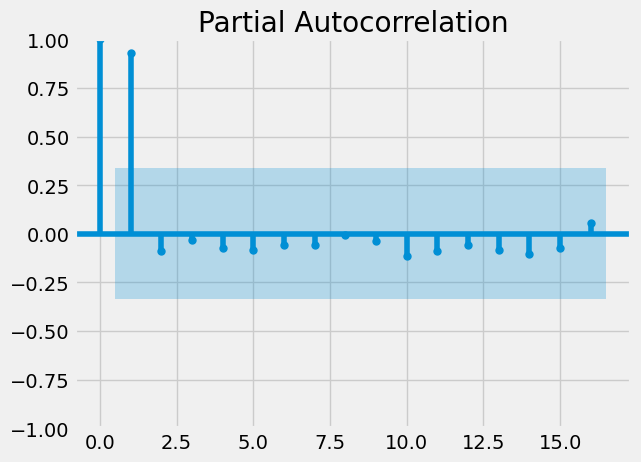

In [46]:
plot_pacf(series)

In [47]:
import warnings
warnings.filterwarnings("ignore", category=Warning)
model = ARIMA(series, order=(5,1,1))
model_fit = model.fit()

In [48]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   34
Model:                 ARIMA(5, 1, 1)   Log Likelihood                 -89.659
Date:                Thu, 03 Jul 2025   AIC                            193.318
Time:                        19:55:31   BIC                            203.793
Sample:                    12-31-1991   HQIC                           196.843
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5109      1.707      0.299      0.765      -2.834       3.856
ar.L2          0.0328      0.614      0.053      0.957      -1.171       1.237
ar.L3          0.2728      0.482      0.566      0.5

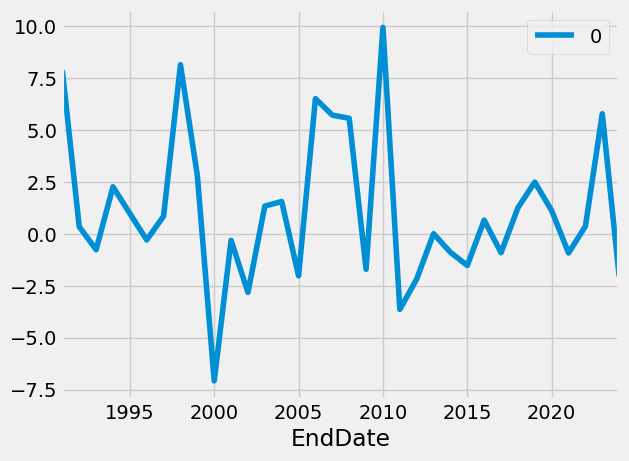

In [49]:
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

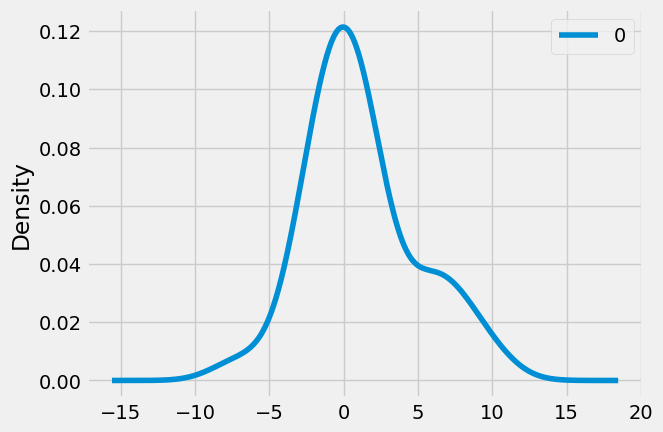

In [50]:
residuals.plot(kind='kde')
plt.show()

In [51]:
print(residuals.describe())

               0
count  34.000000
mean    1.138663
std     3.671384
min    -7.077763
25%    -0.911762
50%     0.520643
75%     2.443244
max     9.948929


In [52]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [53]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=90.695496, expected=91.940000
predicted=99.521848, expected=98.680000
predicted=100.732464, expected=99.470000
predicted=100.507569, expected=101.860000
predicted=105.117004, expected=104.490000
predicted=106.264510, expected=107.780000
predicted=108.374897, expected=111.140000
predicted=113.685747, expected=114.830000
predicted=117.611134, expected=116.710000
predicted=118.917549, expected=119.370000
predicted=121.692274, expected=127.560000
predicted=131.796846, expected=129.570000


In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))

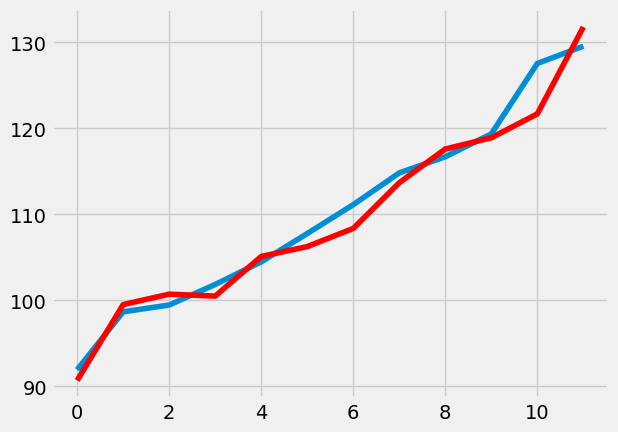

In [55]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [63]:
last_date = series.index[-1]  
future_dates = pd.date_range(start=last_date + pd.DateOffset(years=1), periods=10, freq='Y')

In [57]:
forecast = model_fit.forecast(steps=10)

In [58]:
forecast_series = pd.Series(forecast, index=future_dates)

In [59]:
forecast_series

2025-12-31    131.796846
2026-12-31    134.536738
2027-12-31    138.479301
2028-12-31    143.086043
2029-12-31    145.452968
2030-12-31    147.552790
2031-12-31    150.260489
2032-12-31    152.556300
2033-12-31    153.895724
2034-12-31    155.342096
Freq: YE-DEC, dtype: float64

In [60]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=series.index, y=series.values, name='Historical'))
fig.add_trace(go.Scatter(x=forecast_series.index, y=forecast_series.values, name='Forecast', line=dict(dash='dash')))

fig.update_layout(
    title='Forecast 10 Years Ahead',
    xaxis_title='Year',
    yaxis_title='Value',
    template='simple_white'
)

fig.show()

In [61]:
for date in forecast_series.values:
    print(date)

131.79684610829392
134.53673773016675
138.4793014614647
143.0860432322193
145.45296783480478
147.55279027327202
150.2604888514443
152.55629955064538
153.8957241524941
155.3420962092496


In [62]:
for date in forecast_series.index:
    print(date)

2025-12-31 00:00:00
2026-12-31 00:00:00
2027-12-31 00:00:00
2028-12-31 00:00:00
2029-12-31 00:00:00
2030-12-31 00:00:00
2031-12-31 00:00:00
2032-12-31 00:00:00
2033-12-31 00:00:00
2034-12-31 00:00:00
